# Table of Contents

1. [Package and Data Import](#import)
2. [Data Exploration](#explore)
3. [Feature Engineering and Model Selection](#model)
4. [Next Steps](#next)

# 1. Package and Data Import
<a id='import'></a>

In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
data_path = './data'
data = pd.read_csv(data_path+'/creditcard.csv')
data.sample(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
96891,65990.0,-6.733948,-6.608255,1.869830,1.565714,7.433677,-6.186156,-4.705548,-0.402965,1.124452,...,-1.081041,-0.864272,-2.258160,1.038438,-0.740928,-0.048625,1.503109,-0.491286,4.99,0
222509,143002.0,-0.857379,-0.912749,1.447078,-2.984853,0.172850,-0.609484,-0.440135,-0.011337,-2.111675,...,-0.154828,-0.223708,-0.353841,-0.796373,0.743420,-0.088493,0.011295,0.051841,14.00,0
115067,73736.0,-0.273855,0.093997,2.008847,-0.714815,-0.390581,-0.488838,0.325397,-0.303427,-1.663157,...,0.000801,0.042810,0.118266,0.405467,-0.448023,-0.428263,-0.032781,-0.092757,44.35,0


# 2. Data Exploration
<a id='explore'></a>

In [3]:
data.describe(include='all').iloc[[1,2,5,7],:]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
data[['Time','Amount','Class']].dtypes

Time      float64
Amount    float64
Class       int64
dtype: object

In [5]:
data = data.convert_dtypes()
data[['Time','Amount','Class']].dtypes

Time        Int64
Amount    float64
Class       Int64
dtype: object

In [6]:
# checking null records
if data.isna().sum()[data.isna().sum() > 0].empty:
    print('No null records in the dataset')
else:
    print('Null records exist in the dataset')

No null records in the dataset


In [7]:
# creating class label for visualization purposes
class_name = dict()
class_name[0] = 'Non fraud'
class_name[1] = 'Fraud'

data['Class_name'] = data['Class'].map(class_name)
data['Class_name'].describe()

count        284807
unique            2
top       Non fraud
freq         284315
Name: Class_name, dtype: object

> - `Non Fraud` class seems to be dominant with 284315 records

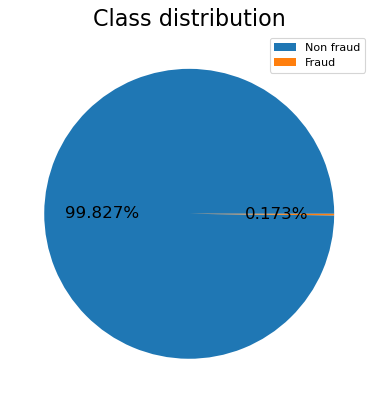

In [8]:
# Class distribution
class_dist = data['Class_name'].value_counts().reset_index()
class_dist.set_index('index',inplace=True)

fig, ax = plt.subplots(figsize=(6,6), dpi= 80)
class_dist.plot.pie(x='index',y='Class_name',autopct='%1.3f%%', labels=['',''], fontsize=15, ax=ax)
ax.legend(labels=class_dist.index)
ax.set_title('Class distribution', fontsize=20)
ax.set_ylabel('')
plt.show()

> - The dataset is highly `imbalanced` with the minorty class (Fraud occurences) consiting of only 0.173% records

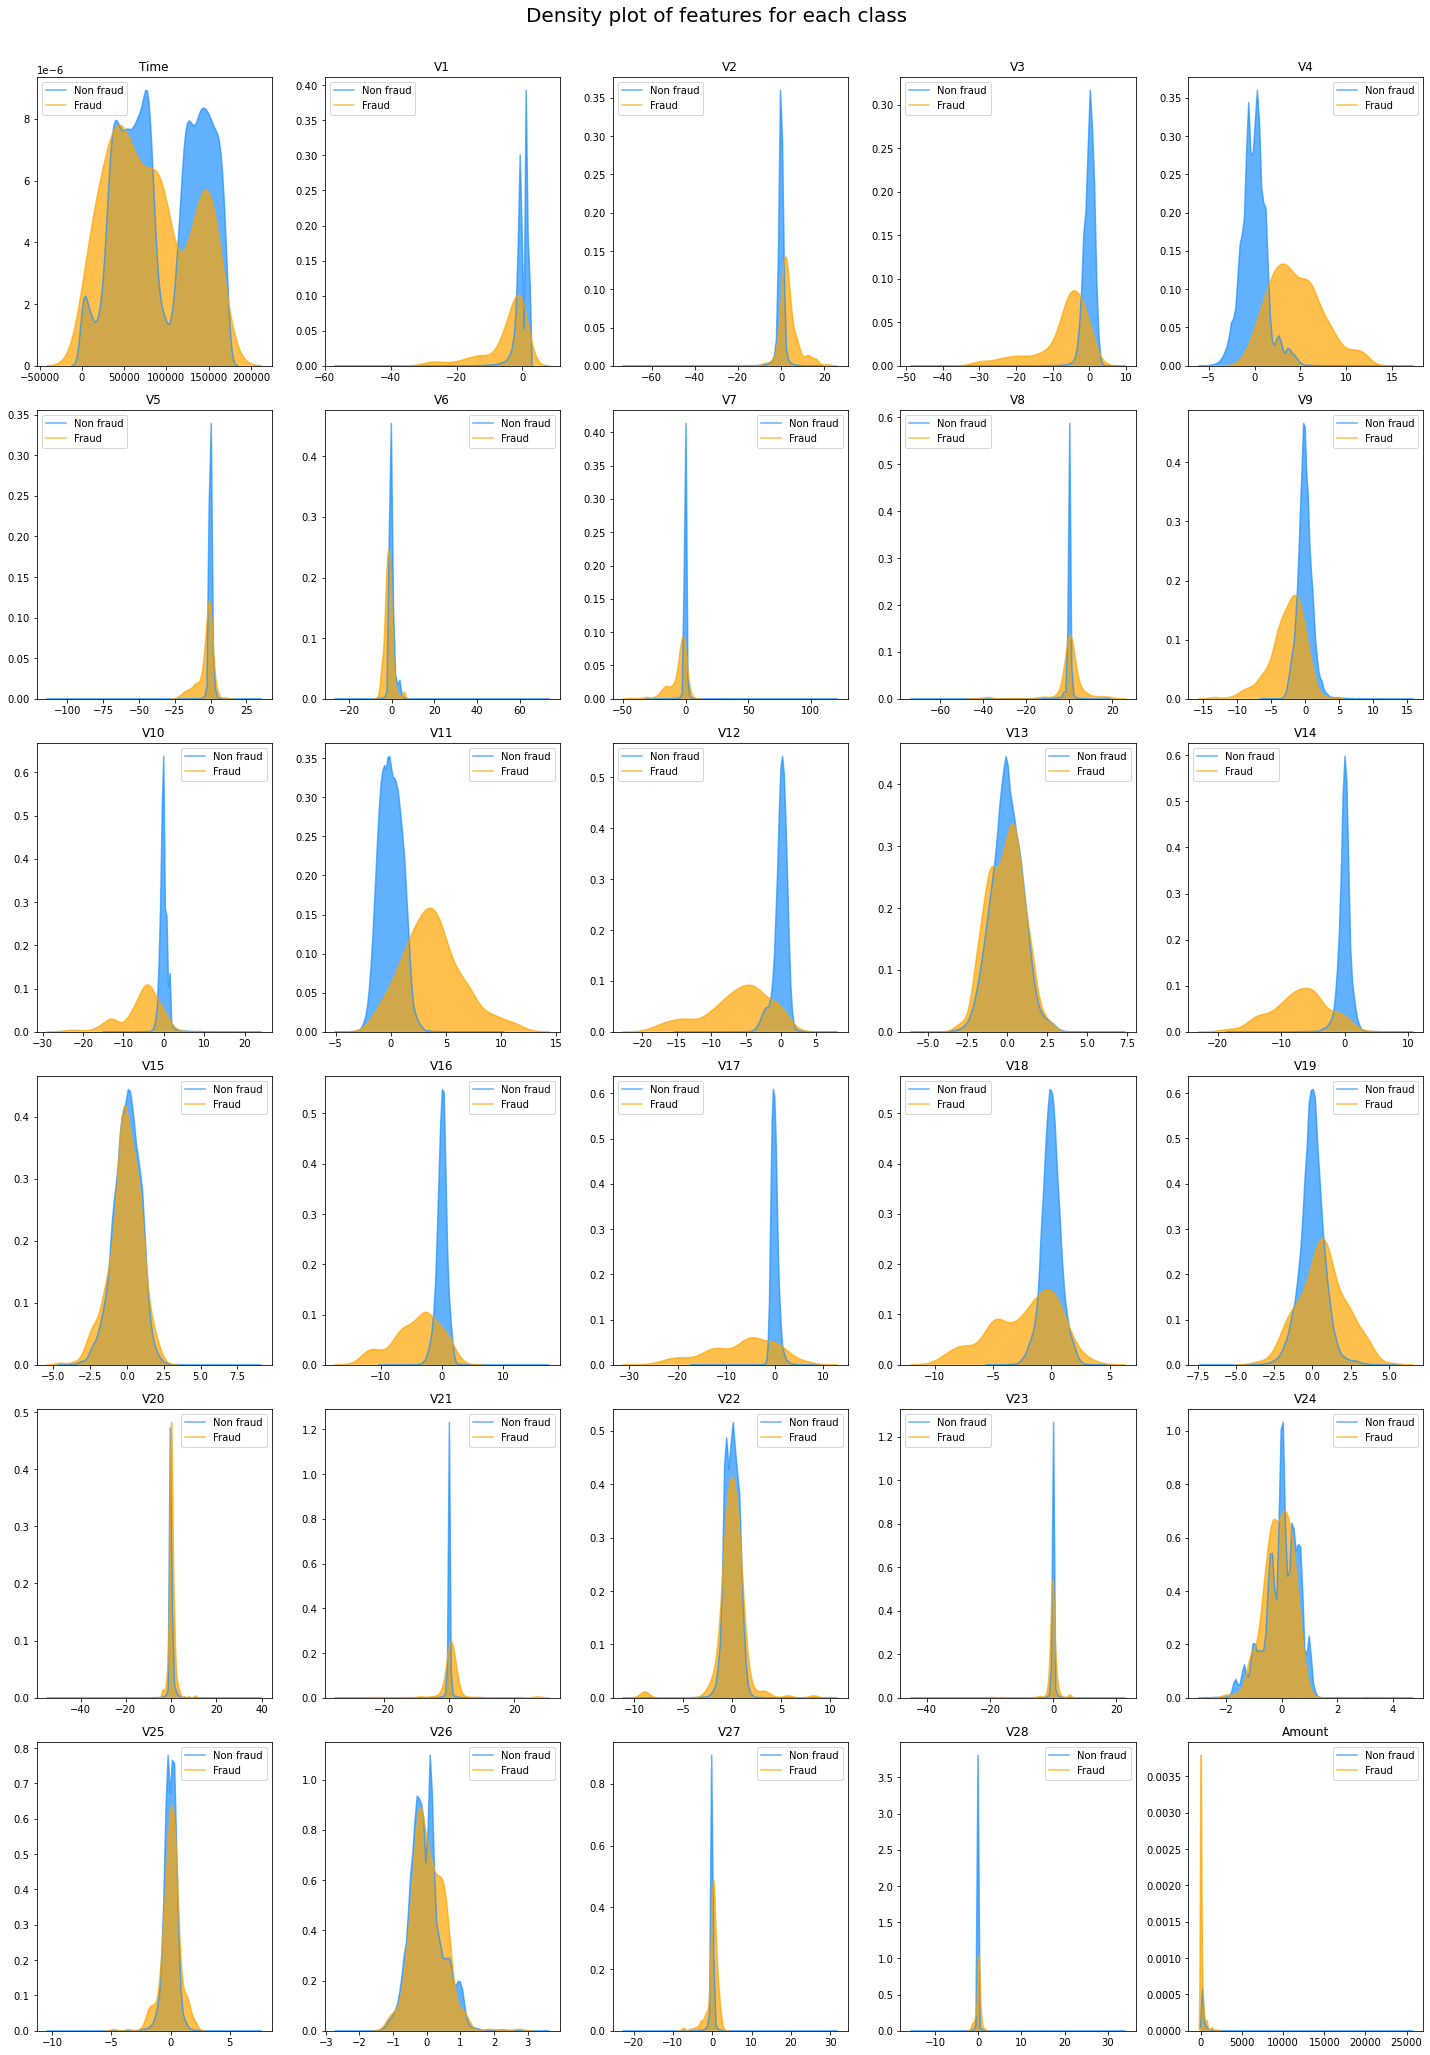

In [9]:
# class wise density plot
fig, ax = plt.subplots(6,5,figsize=(20,30))
feature_cols = data.columns[:-1]

counter = 0
for i in range(6):
    for j in range(5):
        sns.kdeplot(data.loc[data['Class'] == 0, feature_cols[counter]], shade=True, color="dodgerblue", label="Non fraud", alpha=.7, ax=ax[i,j])
        sns.kdeplot(data.loc[data['Class'] == 1, feature_cols[counter]], shade=True, color="orange", label="Fraud", alpha=.7, ax=ax[i,j])
        ax[i,j].set(title=feature_cols[counter])
        counter += 1
fig.suptitle('Density plot of features for each class', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

> - Histogram was not chosen to understand the distribution as it uses frequency and can be affected by the difference in class sizes
> - We can notice a considerable difference in behaviour of certain features within different classes (for ex. V4, V14, V17)
> - Certain features seem to have similar distribution across classes (for ex.V13, V15, V25)
> - **Amount** feature is not on the same scale as other features

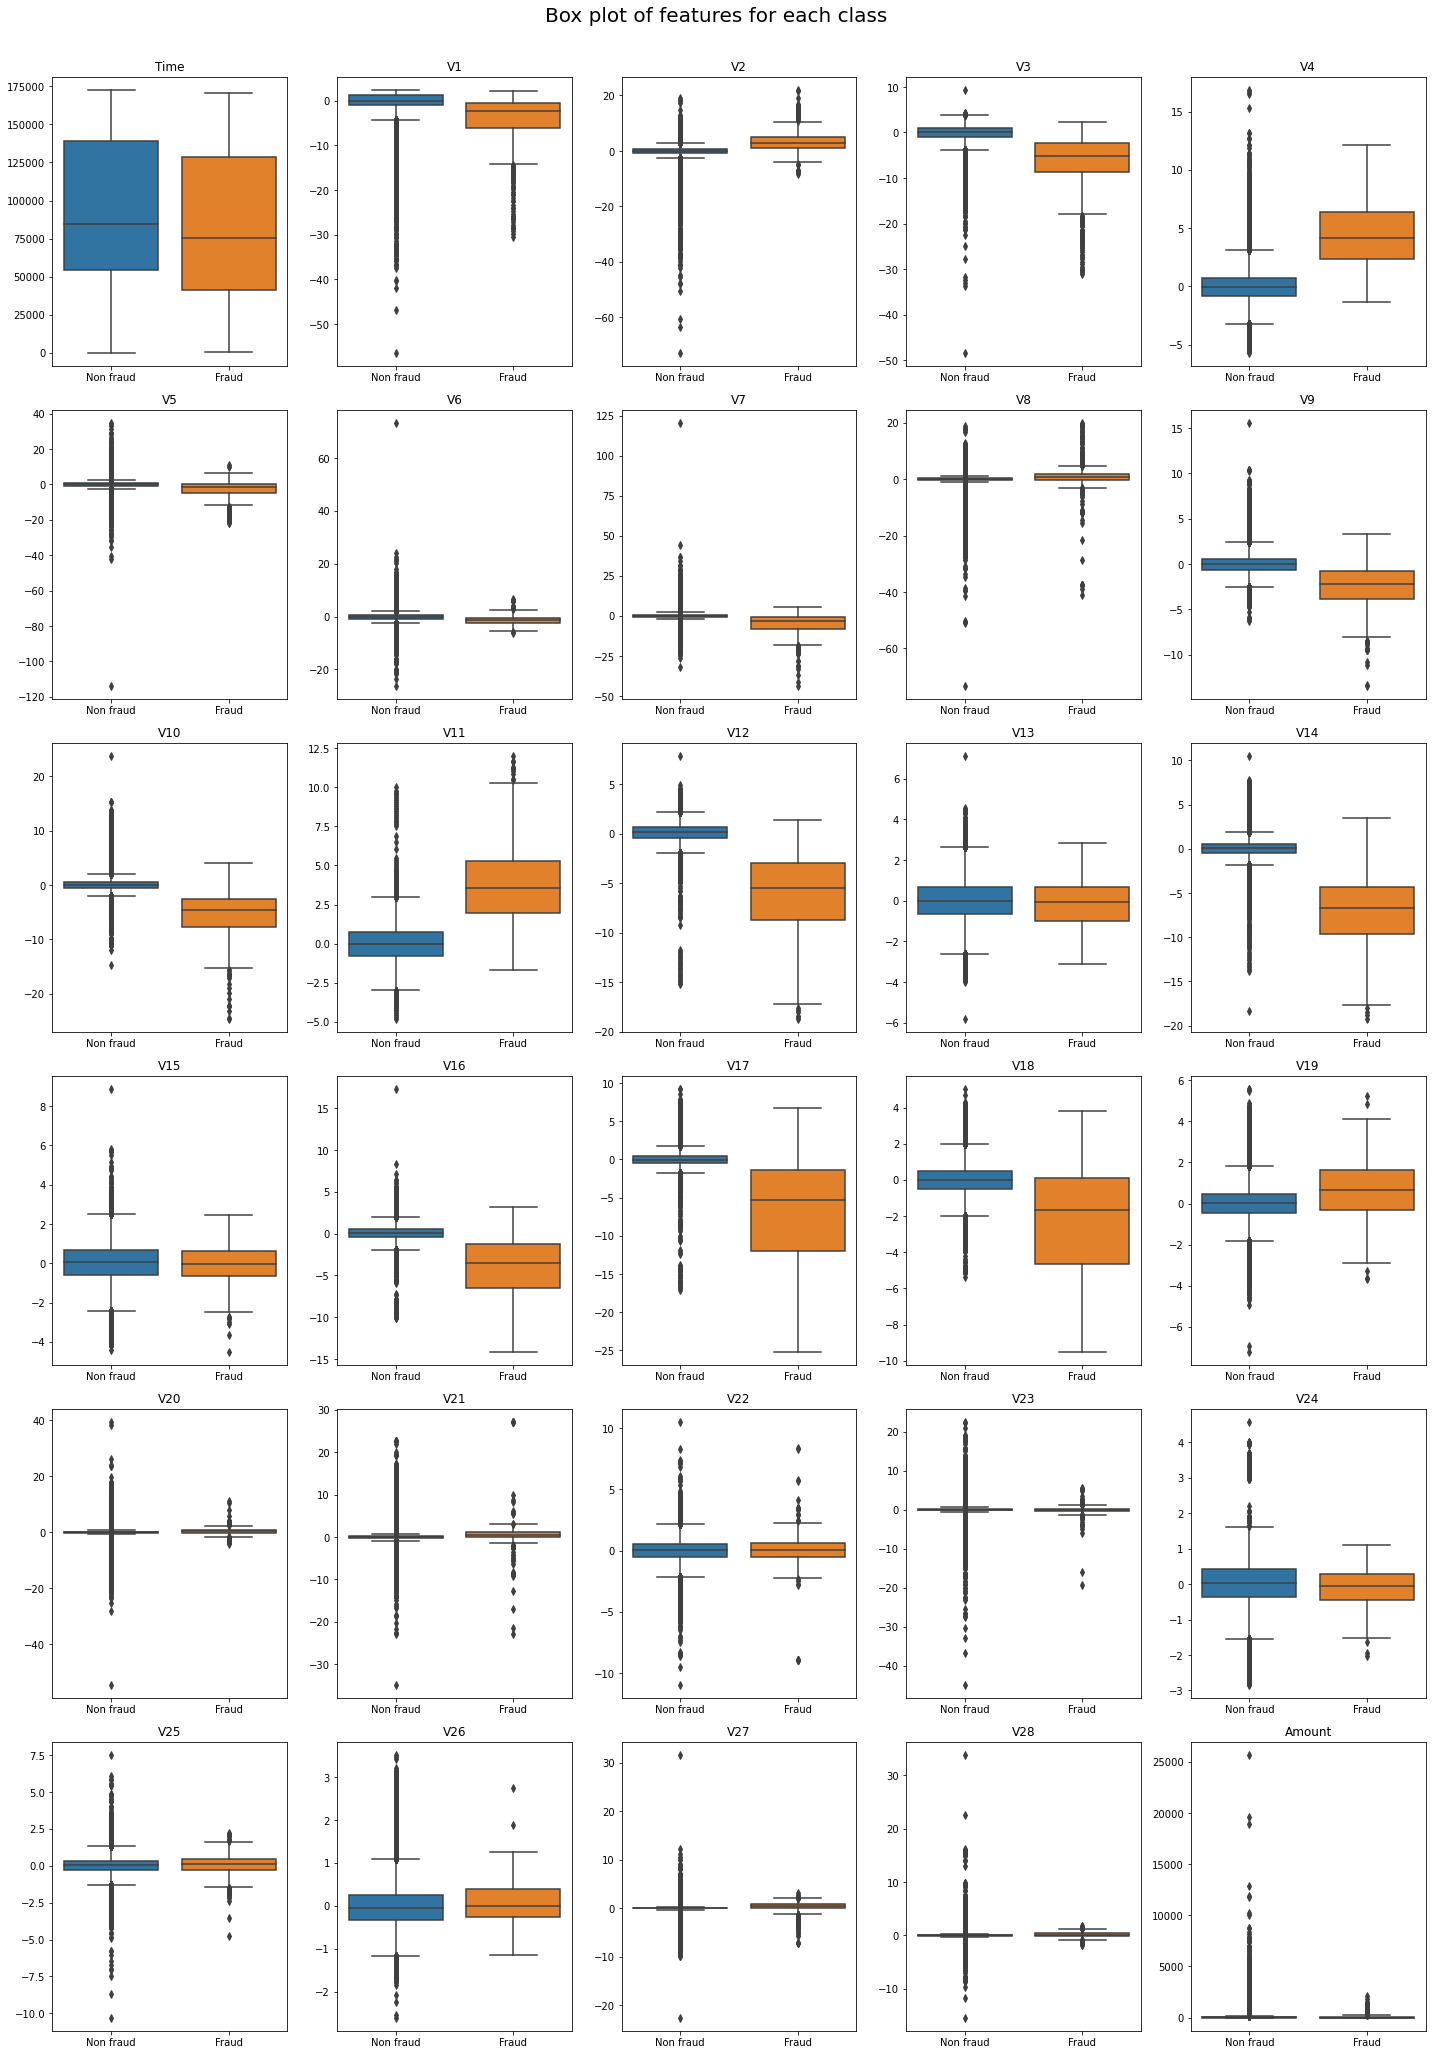

In [10]:
# class wise box plot
fig, ax = plt.subplots(6,5,figsize=(20,30))
feature_cols = data.columns[:-1]

counter = 0
for i in range(6):
    for j in range(5):
        sns.boxplot(x='Class_name', y=feature_cols[counter], data=data, ax=ax[i,j])
        ax[i,j].set(title=feature_cols[counter], xlabel='', ylabel='')
        counter += 1
fig.suptitle('Box plot of features for each class', fontsize=20)   
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

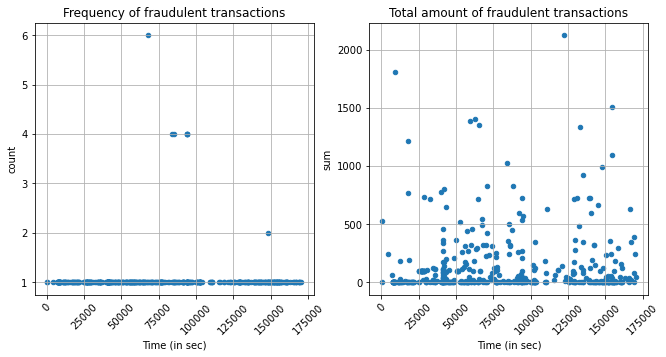

In [11]:
# time elapsed vs transaction analysis
fig, ax = plt.subplots(1,2, figsize=(11,5))
trans_agg = data.loc[data.Class_name == 'Fraud',:].groupby(['Time']) \
            .agg({'Amount':['count','sum','mean']})
trans_agg.columns = [col[1] for col in trans_agg.columns.values]
trans_agg = trans_agg.reset_index()

trans_agg.plot(kind='scatter', x='Time', y='count', marker='o', title='Frequency of fraudulent transactions', grid=True, ax=ax[0])
trans_agg.plot(kind='scatter', x='Time', y='sum', marker='o', title='Total amount of fraudulent transactions', grid=True, ax=ax[1])

for i in range(2):
    ax[i].set_xlabel('Time (in sec)')
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
plt.show()

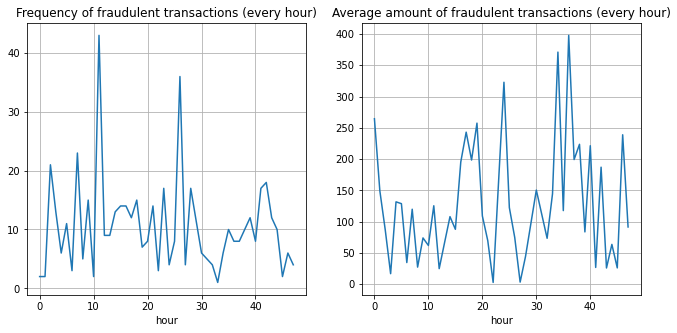

In [12]:
# hourly aggregated time vs transaction analysis
data['hour'] = ((data['Time']/3600)).astype('int64')

fig, ax = plt.subplots(1,2,figsize=(11,5))
data.loc[data['Class']==1].groupby('hour')['Amount'].count().plot(ax=ax[0], grid=True, title='Frequency of fraudulent transactions (every hour)')
data.loc[data['Class']==1].groupby('hour')['Amount'].mean().plot(ax=ax[1], grid=True, title='Average amount of fraudulent transactions (every hour)')

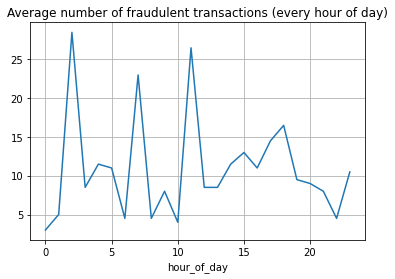

In [13]:
# hour of day aggregate vs transaction analysis
hourly_agg = data.loc[data['Class']==1].groupby('hour').agg({'Amount':'count'})
hourly_agg = hourly_agg.reset_index()
hourly_agg['hour_of_day'] = (hourly_agg['hour'] % 24).astype('int64')

hourly_agg.groupby('hour_of_day')['Amount'].mean().plot(grid=True, title='Average number of fraudulent transactions (every hour of day)')
plt.show()
plt.close()

# 3. Feature Engineering and Model Selection
<a id='model'></a>

In [14]:
# function to evaluate model performance using different metrics
def model_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_name = type(model).__name__
    accuracy = round(accuracy_score(y_test,y_pred),3)
    recall = recall_score(y_test,y_pred)
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'Accuracy score: {accuracy}')
    print(f'Classification Report:\n {classification_report(y_test,y_pred)}')
    print(f'Recall score: {recall}')
    print(f'F2 score: {f2_score}')
    print(f'AUC score: {auc_score}')
    
    fig, ax = plt.subplots(1,3, figsize=(18,5), dpi=80)

    class_name = ['Non fraud','Fraud']
    cf_matrix = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cf_matrix).plot(ax=ax[0], cmap='Blues')
    ax[0].set_xticklabels(class_name)
    ax[0].set_yticklabels(class_name)
    ax[0].set_title('Confusion Matrix')
    
    average_recall = average_precision_score(y_test, y_pred)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax[1])
    ax[1].set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_recall))
    
    plot_roc_curve(model, X_test, y_test, ax=ax[2])
    ax[2].set_title('2-class ROC curve: AUC={0:0.2f}'.format(auc_score))
    
    return (model_name,recall,auc_score,f2_score)

In [15]:
# input data preparation
input_data = data.copy()
input_data['hour_of_day'] = (input_data['hour'] % 24).astype('int64')
input_data.drop(columns=['Class_name','hour','Time'],inplace=True)
hour_numeric = pd.get_dummies(data=input_data['hour_of_day'])

feature_cols = list(input_data.drop(['Class','hour_of_day'], axis=1).columns) + list(hour_numeric.columns)
label_col = ['Class']

input_data = pd.concat([input_data,hour_numeric],axis=1)
input_data = input_data[feature_cols+label_col]
input_data.sample(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,15,16,17,18,19,20,21,22,23,Class
214365,-1.314646,2.068069,-1.141075,0.730622,1.457319,0.346335,0.755452,0.786026,-1.671412,-1.232544,...,0,0,0,0,0,0,0,0,0,0
211499,2.183153,-0.506390,-1.658789,-0.210685,-0.258486,-1.305419,0.135298,-0.476209,-0.700279,0.917064,...,0,0,0,0,0,0,0,0,0,0
62024,0.813419,-1.585547,1.311351,-1.038439,-1.676727,1.016780,-1.298443,0.497037,2.848124,-1.499764,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# scaling transaction amount
input_data['Amount_Scaled'] = StandardScaler().fit_transform(input_data[['Amount']])

In [17]:
# train test split
X = input_data[[col for col in feature_cols if col not in ['Amount']]+['Amount_Scaled']]
y = input_data[label_col[0]].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

/Users/subikshaa/anaconda3/envs/credit_fraud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score: 0.999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.64      0.73       148

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Recall score: 0.6351351351351351
F2 score: 0.6704707560627673
AUC score: 0.8174796374427068


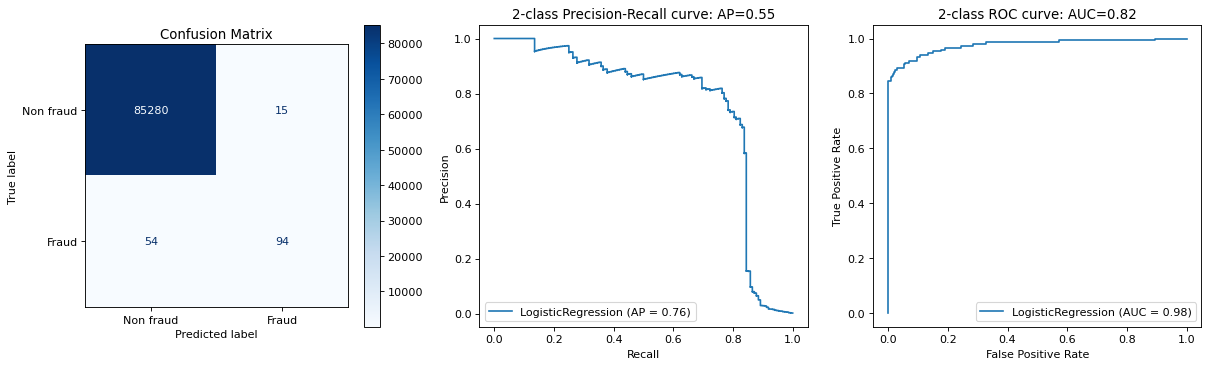

In [18]:
# baseline logistic regression model without handling imbalance
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_perf = model_performance(lr, X_test, y_test)

> - Accuracy of the model is `99.9%` but looking at the confusion matrix shows the presence of a lot of False negatives
> - While we want to reduce the false positives (to save the cost of investigating many incorrect fraud alerts), false negatives are more important to the business here because **incorrectly identifying a fraudulent transaction as a non-fraudulent transaction costs the business more**
> - Recall is a good measure to estimate the presence of false negatives in the predictions
$$recall=\frac{True Positives}{True Positives + False Negatives}$$
> - Recall of the positive class (fraud) is just `63.5%`
> - **F2 score** prioritizes recall over precision and estimates F score and hence can be the appropriate metric for this business-case

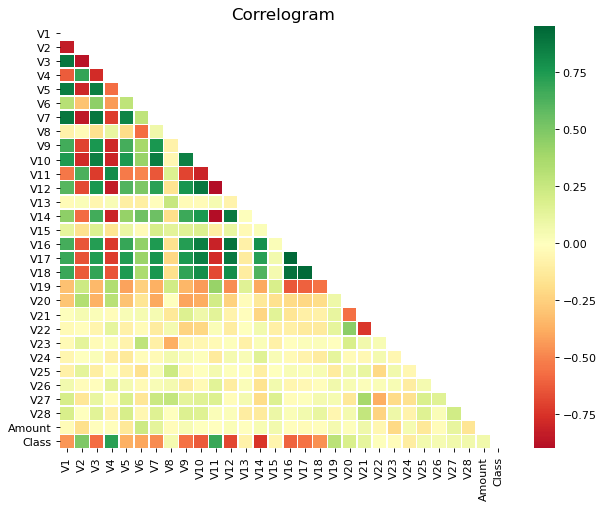

In [19]:
# Undersampling majority class to find feature correlations
equal_classes = pd.concat([input_data.loc[input_data.Class==0].sample(n=input_data.loc[input_data.Class==1].shape[0]), input_data.loc[input_data.Class==1]])
# equal_classes.drop(columns=['Class_name','hour'],inplace=True)

fig, ax = plt.subplots(figsize=(9,7), dpi=80)
feature_cor = equal_classes[feature_cols[:-24]+label_col].corr()
mask = np.triu(np.ones_like(feature_cor, dtype=np.bool))
sns.heatmap(feature_cor, mask=mask,xticklabels=feature_cor.columns, yticklabels=feature_cor.columns, cmap='RdYlGn', center=0,linewidths=.5, ax=ax)
ax.set_title('Correlogram', fontsize=15)
plt.show()

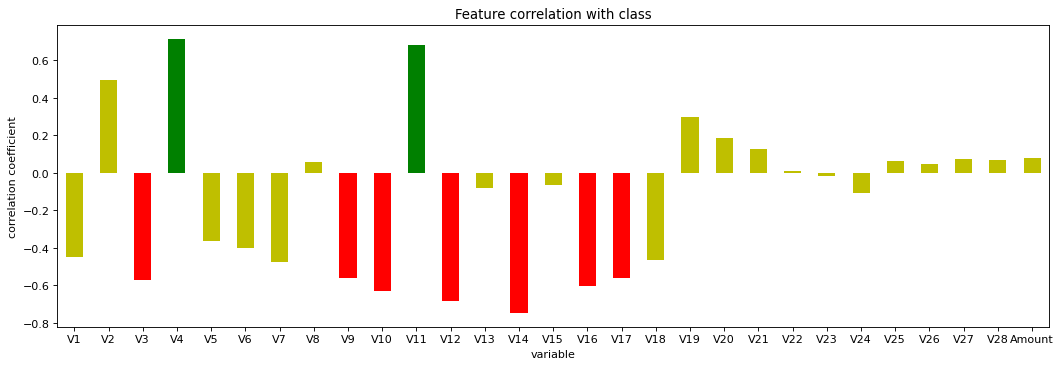

In [20]:
fig, ax = plt.subplots(figsize=(16,5), dpi=80)
class_cor = feature_cor[-1:].melt(value_vars=feature_cols[:-24])
class_cor['color'] = 'g'
class_cor.loc[(class_cor['value'] < 0.5)&(class_cor['value'] > -0.5), 'color'] = 'y'
class_cor.loc[(class_cor['value'] < -0.5), 'color'] = 'r'
class_cor.plot.bar(x='variable', y='value', rot=0, width=0.5, color=class_cor.color.to_list(), legend=False, ax=ax)
ax.set_title('Feature correlation with class')
ax.set_ylabel('correlation coefficient')
plt.show()

In [21]:
# SMOTE sampling on Train data
smote = SMOTE(sampling_strategy={1:int(len(np.where(y_train==0)[0])/4)}, random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

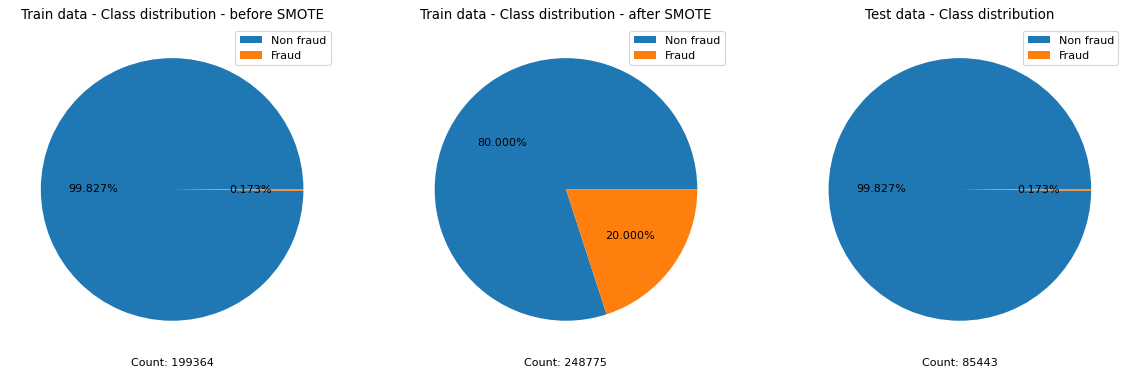

In [22]:
fig, ax = plt.subplots(1,3, figsize=(18,6), dpi= 80)
ax[0].pie(x=np.unique(y_train, return_counts=True)[1]/np.unique(y_train, return_counts=True)[1].sum(), autopct='%1.3f%%', labels=['',''])
ax[0].legend(labels=['Non fraud','Fraud'])
ax[0].set_title('Train data - Class distribution - before SMOTE')
ax[0].set_ylabel('')
ax[0].set_xlabel(f'Count: {len(y_train)}')

ax[1].pie(x=np.unique(y_resampled, return_counts=True)[1]/np.unique(y_resampled, return_counts=True)[1].sum(), autopct='%1.3f%%', labels=['',''])
ax[1].legend(labels=['Non fraud','Fraud'])
ax[1].set_title('Train data - Class distribution - after SMOTE')
ax[1].set_ylabel('')
ax[1].set_xlabel(f'Count: {len(y_resampled)}')

ax[2].pie(x=np.unique(y_test, return_counts=True)[1]/np.unique(y_test, return_counts=True)[1].sum(), autopct='%1.3f%%', labels=['',''])
ax[2].legend(labels=['Non fraud','Fraud'])
ax[2].set_title('Test data - Class distribution')
ax[2].set_ylabel('')
ax[2].set_xlabel(f'Count: {len(y_test)}')

plt.show()

/Users/subikshaa/anaconda3/envs/credit_fraud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score: 0.999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.69      0.80      0.74       148

    accuracy                           1.00     85443
   macro avg       0.85      0.90      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Recall score: 0.8040540540540541
F2 score: 0.7787958115183247
AUC score: 0.9017163405858521


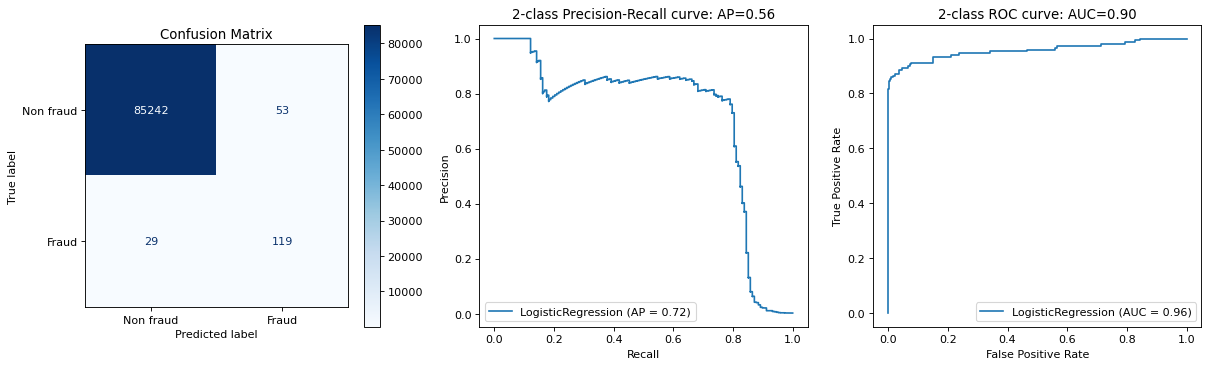

In [23]:
# Logistic regression - on over sampled data

lr2 = LogisticRegression(random_state=42)
lr2.fit(X_resampled, y_resampled)
lr2_perf = model_performance(lr2, X_test, y_test)

Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Recall score: 0.777027027027027
F2 score: 0.8041958041958042
AUC score: 0.8884666174469211


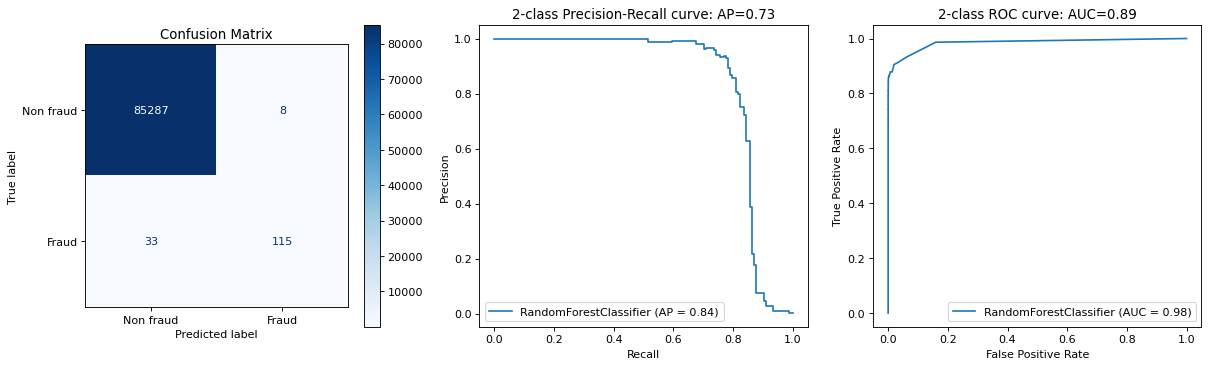

In [24]:
# Random Forest Classifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)
rf_perf = model_performance(rf, X_test, y_test)

Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Recall score: 0.7635135135135135
F2 score: 0.7957746478873239
AUC score: 0.8817274467151365


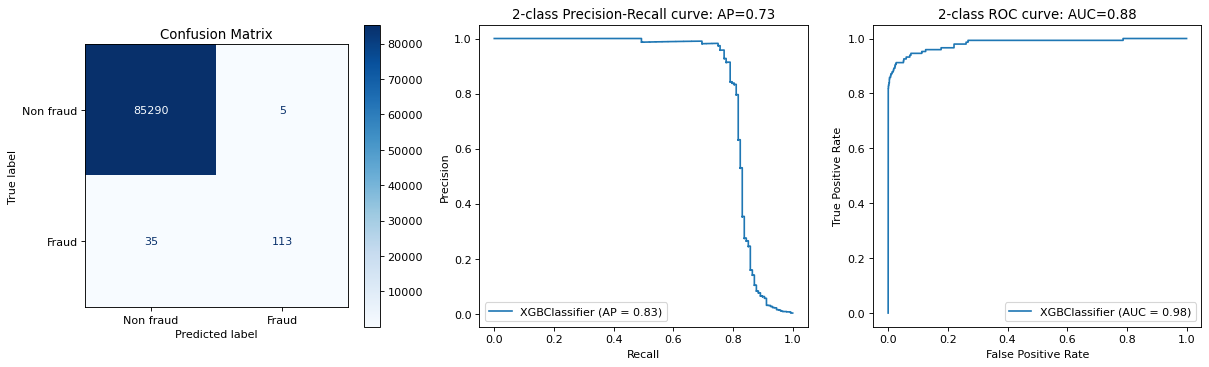

In [25]:
# XGB Classifier

xgb_mod = xgb.XGBClassifier(random_state=42)
xgb_mod.fit(X_resampled, y_resampled)
xgb_perf = model_performance(xgb_mod, X_test, y_test)

In [26]:
model_performances = list()
model_performances.append(lr_perf)
model_performances.append(lr2_perf)
model_performances.append(rf_perf)
model_performances.append(xgb_perf)

In [27]:
pd.DataFrame(model_performances, columns=['Model_name','recall','AuROC','F2_score']).sort_values('F2_score', ascending=False)

,Model_name,recall,AuROC,F2_score
2,RandomForestClassifier,0.777027,0.888467,0.804196
3,XGBClassifier,0.763514,0.881727,0.795775
1,LogisticRegression,0.804054,0.901716,0.778796
0,LogisticRegression,0.635135,0.817480,0.670471


> **Random Forest Classifier** shows the best F2 score performance `(80.4%)` out of the models

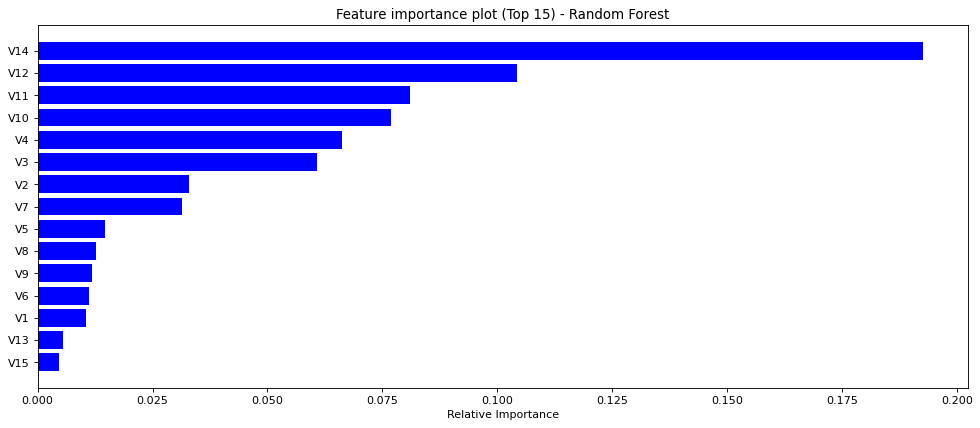

In [28]:
feat_imp = rf.feature_importances_[:15]
indices = np.argsort(feat_imp)

fig, ax = plt.subplots(figsize=(15,6), dpi=80)
plt.title('Feature importance plot (Top 15) - Random Forest')
ax.barh(range(len(indices)), feat_imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# 4. Next Steps
<a id='next'></a>

- Outlier analysis and removal
- PCA for dimensionality reduction
- Performing cross validation
- Using Shap or LIME for model explainability